# Energies and logits

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

In [20]:
fp = "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_2/3VRL_high__vs__3VRL_looser/attributions/v2.0-2/attribution_records.json"
fp_test_1 = "../data/MiniAbsolut_Splits/MiniAbsolut_Seed2/3VRL/high_test_5000.tsv"
fp_test_2 = "../data/MiniAbsolut_Splits/MiniAbsolut_Seed2/3VRL/looserX_test_5000.tsv"

df_test_1 = pd.read_csv(fp_test_1, sep="\t")
df_test_1["class"] = "positive"
df_test_2 = pd.read_csv(fp_test_2, sep="\t")
df_test_2["class"] = "negative"
df_test = pd.concat([df_test_1, df_test_2], axis=0)

with open(fp, "r") as f:
    data = json.load(f)

In [21]:
df_test

,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,class
0,21441,3232108_00a,CASWIWYFDVW,True,CASWIWYFDVW,-97.84,137570-BSDLRDDSLU,mascotte,3VRL,positive
1,1746,5717631_00a,CARGQLLLRAFDYW,True,CARGQLLLRAF,-98.82,137570-BSDLRDDSLU,mascotte,3VRL,positive
2,23533,7042338_00a,CARVGALLCFYYAMDYW,False,CARVGALLCFY,-98.92,137570-BSDLRDDSLU,mascotte,3VRL,positive
3,24546,2643075_00a,CARPYLFMDLWYFDVW,True,CARPYLFMDLW,-98.25,137570-BSDLRDDSLU,mascotte,3VRL,positive
4,24013,2530684_00a,CARNHLLLRFYYFDYW,True,CARNHLLLRFY,-97.92,137570-BSDLRDDSLU,mascotte,3VRL,positive
...,...,...,...,...,...,...,...,...,...,...
4995,50115,5675855_00a,CARWTLFTTVVAWDFDVW,True,CARWTLFTTVV,-94.60,137570-BSDLRDDSLU,looserX,3VRL,negative
4996,6412,4705744_04a,CARGIYYGIWYFDVW,True,IYYGIWYFDVW,-95.83,137570-BSDLRDDSLU,looserX,3VRL,negative
4997,150264,4154112_03a,CARYPLLLRGFDYW,False,YPLLLRGFDYW,-94.88,137442-BRDSLLUDLS,looserX,3VRL,negative
4998,146323,747612_01a,CARILWLEDWYFDVW,True,ARILWLEDWYF,-93.43,137570-BLDSRRSURS,looserX,3VRL,negative


In [22]:
df = pd.DataFrame.from_records(data)
df = pd.merge(df, df_test, left_on="slide", right_on="Slide")
df.head()

,slide,logits,expits,y_pred,y_true,is_pred_correct,DeepLIFT_LOCAL_v2.0-2,DeepLIFT_GLOBAL_R10_v2.0-2,exec_time,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,class
0,CARWGFLFWYF,36.035297,1.0,1,1,True,"[[0.6532908082008362, 2.525751829147339, 0.0, ...","[[-3.4908359050750732, 2.852792263031006, -10....",18184.208947,1564,6262006_00a,CARWGFLFWYFDVW,True,CARWGFLFWYF,-106.40,137570-BSDLRDDSLU,mascotte,3VRL,positive
1,CARVHLLLLYF,35.692356,1.0,1,1,True,"[[0.5929000377655029, 3.0686094760894775, 0.0,...","[[-2.609302282333374, 3.1613006591796875, -9.6...",18184.208947,2123,3919327_00a,CARVHLLLLYFDYW,True,CARVHLLLLYF,-107.71,137570-BSDLRDDSLU,mascotte,3VRL,positive
2,CARWGWLLQIL,35.528095,1.0,1,1,True,"[[0.7790840864181519, 2.0747859477996826, 0.0,...","[[-4.884578704833984, 2.9810032844543457, -12....",18184.208947,28874,5157580_00a,CARWGWLLQILTYW,True,CARWGWLLQIL,-105.16,137570-BSDLRDDSLU,mascotte,3VRL,positive
3,CARVGWLLPIL,34.038166,1.0,1,1,True,"[[0.0, 2.375030040740967, 0.0, 0.0, 0.0, 0.515...","[[-4.852635383605957, 2.7822837829589844, -11....",18184.208947,17517,1349039_00a,CARVGWLLPILFDYW,True,CARVGWLLPIL,-105.31,137570-BSDLRDDSLU,mascotte,3VRL,positive
4,CARWGLLLYYF,33.931423,1.0,1,1,True,"[[0.710521399974823, 2.989356279373169, 0.0, 0...","[[-3.28698992729187, 2.9863240718841553, -10.5...",18184.208947,3854,564228_00a,CARWGLLLYYFDYW,True,CARWGLLLYYF,-105.77,137570-BSDLRDDSLU,mascotte,3VRL,positive


<AxesSubplot: xlabel='Energy', ylabel='logits'>

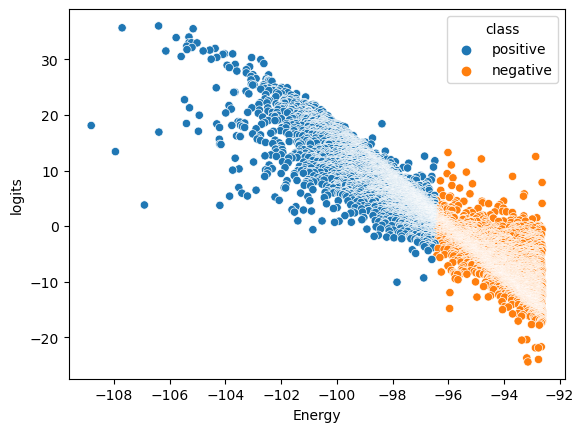

In [23]:
sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
)